# Perform a more intellegent approach on 'Zhou et al.'s Band gap data'

## Import the libraries we will be using

In [1]:
# read in data with pandas
import pandas as pd
# use numpy for vector and matrix operations
import numpy as np

# composition is a custom made python file that generates composition-based feature vectors (CBFV)
import composition
# utils is a custom made python file that has some useful functions
import utils

# make nice figures
import matplotlib.pyplot as plt
# machine learnign algorithms
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
# preprocessing for the features
from sklearn.preprocessing import StandardScaler, Normalizer
# feature reduction
from sklearn.decomposition import PCA
# import model selection tools
from sklearn.model_selection import cross_validate, cross_val_score,\
                                    cross_val_predict, learning_curve, \
                                    GridSearchCV, KFold, train_test_split
# grab metrics to evaluate our models
from sklearn.metrics import confusion_matrix, classification_report,\
                            r2_score, mean_squared_error

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# read in band gap data from Zhou et al. publication:
# J. Phys. Chem. Lett., 2018, 9 (7), pp 1668–1673
#DOI: 10.1021/acs.jpclett.8b00124
#Publication Date (Web): March 13, 2018
df_band_gap = pd.read_excel('jz8b00124_si_002.xlsx')

# excel sheet is edited to fix formula "GaAs0.1P0.9G1128" to "GaAs0.1P0.9"
df_band_gap.replace("GaAs0.1P0.9G1128", "GaAs0.1P0.9", inplace=True)

# set the columns names to 'formula' and 'target'
df_band_gap.columns = ['formula', 'target']

# fix the formula with bad formatting "AxBy, 102"
df_band_gap['formula'] = [formula.split(',')[0] for formula in df_band_gap['formula']]


In [3]:
df_band_gap['formula'].value_counts()

CdS               27
GaSe              26
GaAs              25
CdSe              25
As2S3             24
ZnO               22
InAs              21
InSe              20
InP               20
ZnS               20
InSb              19
PbTe              18
ZnTe              18
CdSb              17
ZnSe              16
CdTe              16
GaN               16
TlBr              16
AlSb              15
GaSb              15
CuCl              14
PbS               14
Mg2Sn             13
GaS               13
GaTe              13
TlSe              13
Ag3SbS3           12
PbSe              12
TlInSe2           11
AlP               11
                  ..
Er6MnBi2           1
Li3Ti3(PO4)4       1
Pb4V2Se6O21        1
CaSnO3             1
Tl2TeS3            1
Nd2Sn3Se9          1
Y2Ge5Ir3           1
CuYO2              1
Fe2S               1
Th2Se5             1
Ho2S3              1
K3Hg               1
Ag7AsS6            1
Co5RuO8            1
K8Ga8Si38          1
NdAl4Ge2Au         1
Hg3S2Bi2Cl8  

Text(0,0.5,'# of instances')

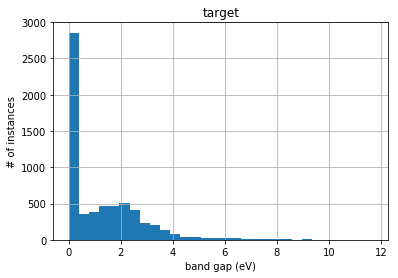

In [4]:
df_band_gap.hist(bins=30)
plt.xlabel('band gap (eV)')
plt.ylabel('# of instances')

**Upon closer inspection of the data, we now see there are two issues we need to address with our data**

1. The data contain duplicate formulae entries. 
    - *This means that the same formula could end up in both training, validation and test sets. This will give us an overly optimisitc model.*
2. The data we are trying to learn contain metals & non-metals. 
    - *This has the effect of giving us very imbalanced data.*


To correct for these two issues we will
1. take the average band gap for duplicate composition entries
2. separate remove the metal band gaps from our regression


In [5]:
## take the average of duplicate composition entries
df_band_gap = df_band_gap.groupby('formula').mean().reset_index()

In [6]:

print('data size before removing metals:', df_band_gap.shape)
## separate the metal and non-metal compounds
df_band_gap = df_band_gap[df_band_gap['target'] > 0]
print('data size after removing metals:', df_band_gap.shape)

data size before removing metals: (4934, 2)
data size after removing metals: (2483, 2)


In [7]:
# now that we have a better representation of the data, lets generate features
X, y, formula = composition.generate_features(df_band_gap)

The element: Eu from formula Ag0.5Eu1.75GeS4 is not currently supported in our database
The element: Eu from formula Ba3EuP3O12 is not currently supported in our database
The element: Eu from formula Eu1.83Ta15O32 is not currently supported in our database
The element: Eu from formula Eu2Ga2GeS7 is not currently supported in our database
The element: Eu from formula Eu2O3 is not currently supported in our database
The element: Eu from formula Eu2Se3 is not currently supported in our database
The element: Eu from formula Eu2SnSe5 is not currently supported in our database
The element: Eu from formula Eu3As2 is not currently supported in our database
The element: Eu from formula Eu3Bi4S9 is not currently supported in our database
The element: Eu from formula Eu3In2P4 is not currently supported in our database
The element: Eu from formula Eu3P2 is not currently supported in our database
The element: Eu from formula Eu3S4 is not currently supported in our database
The element: Eu from form

In [8]:
X.head()

,sum_C-0,sum_C-1,sum_C-10,sum_C-11,sum_C-12,sum_C-13,sum_C-14,sum_C-15,sum_C-16,sum_C-17,...,range_voro_coord_subs_atom_mass,range_voro_coord_subs_atom_rad,range_voro_coord_subs_bp,range_voro_coord_subs_elec_aff,range_voro_coord_subs_first_ion_en,range_voro_coord_subs_hfus,range_voro_coord_subs_mol_vol,range_voro_coord_subs_mp,range_voro_coord_subs_polzbl,range_voro_coord_subs_therm_cond
0,43.383607,15.081967,8.655738,0.0,26.377049,26.377049,60.124590,0.0,0.0,0.0,...,17.782,4.85,1079.0,6.613,8.22324,5.14089,9.7,297.91,0.85,74.0
1,43.648000,15.296000,8.448000,0.0,26.440000,26.440000,59.824000,0.0,0.0,0.0,...,17.782,4.85,1079.0,6.613,8.22324,5.14089,9.7,297.91,0.85,74.0
2,43.383607,15.081967,8.655738,0.0,26.377049,26.377049,60.124590,0.0,0.0,0.0,...,17.782,4.85,1079.0,6.613,8.22324,5.14089,9.7,297.91,0.85,74.0
3,43.900000,15.500000,8.250000,0.0,26.500000,26.500000,59.537500,0.0,0.0,0.0,...,17.782,4.85,1079.0,6.613,8.22324,5.14089,9.7,297.91,0.85,74.0
4,43.561290,15.225806,8.516129,0.0,26.419355,26.419355,59.922581,0.0,0.0,0.0,...,17.782,4.85,1079.0,6.613,8.22324,5.14089,9.7,297.91,0.85,74.0


**Once the data has been vectorized, we can now split it into our training and test set**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## If we want to use models that rely on gradient descent, we need to scale the data for computational reasons

In [10]:
# we now want to process our data. We are going to use the SVR algorithm.
# This algorithm is based on gradient descent and needs similar feature scales.

# scale each column of data to have a mean of 0 and a variance of 1
scaler = StandardScaler()
# normalizes each row in the data
normalizer = Normalizer()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(normalizer.fit_transform(X_train_scaled),
                              columns=X_train.columns.values)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(normalizer.transform(X_test_scaled),
                              columns=X_test.columns.values)

R2 score = -3424243406880163.5


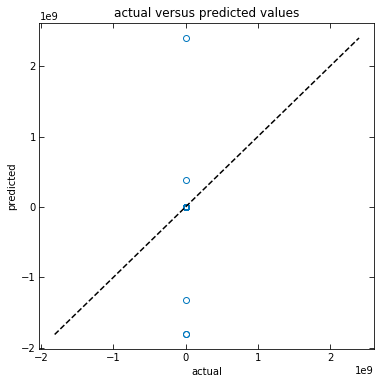

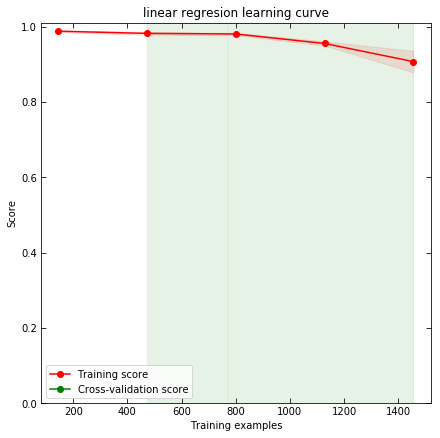

In [11]:
# Initialize a "LinearRegression" object. This will allow us to do a simple linear regression on the data
lr = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(lr, X_train_scaled, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)
title = "linear regresion learning curve"
utils.plot_learning_curve(lr, title, X_train_scaled, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

**We can see that the linear regression has major problems modeling this data**

## Lets try a ridgre regression instead

We can instead try a ridge regression. This technique is still a linear model, however it applies regularization on the feature weights.

R2 score = 0.6785133827942416


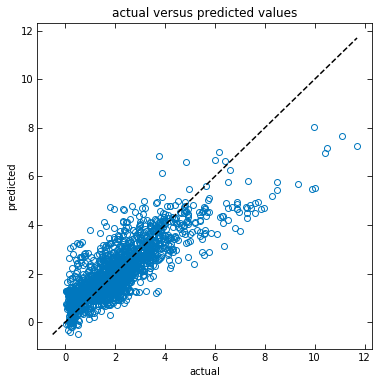

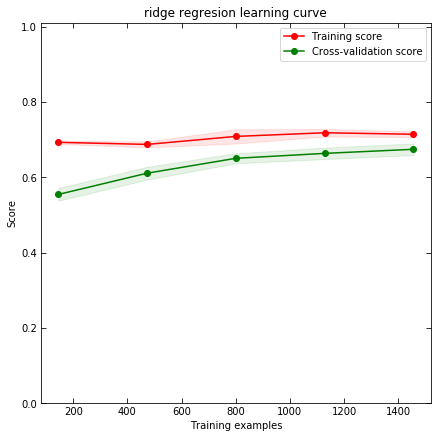

In [12]:
# Initialize a "Ridge" object. This will allow us to do a ridge regression on the data
rr = Ridge()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(rr, X_train_scaled, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

title = "ridge regresion learning curve"
utils.plot_learning_curve(rr, title, X_train_scaled, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

**Unlike a linear regression, we can control the extent of regularization using a model hyperparameters. **
Lets try changing this to see if we can get better results.

R2 score = 0.7372468797974612


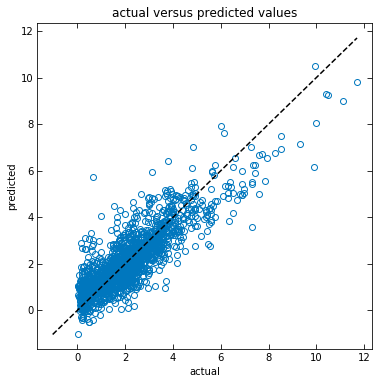

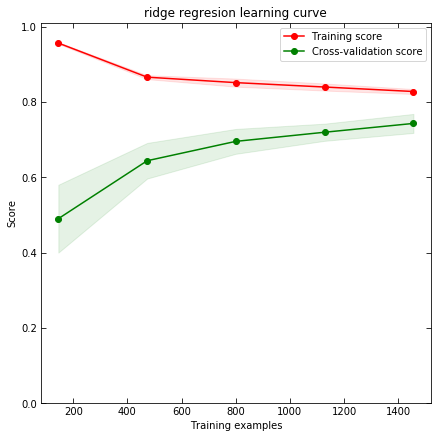

In [13]:
# Initialize a "Ridge" object. This will allow us to do a ridge regression on the data
rr = Ridge(alpha=0.01)
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(rr, X_train_scaled, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

title = "ridge regresion learning curve"
utils.plot_learning_curve(rr, title, X_train_scaled, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

## We can also try to reduce the number of features using PCA

In [14]:
# We might want to reduce our feature space to make learning easier
pca = PCA(n_components=100)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_scaled))
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled))

### Trying the linear regression with lower feature dimensions

R2 score = 0.6738811347740391


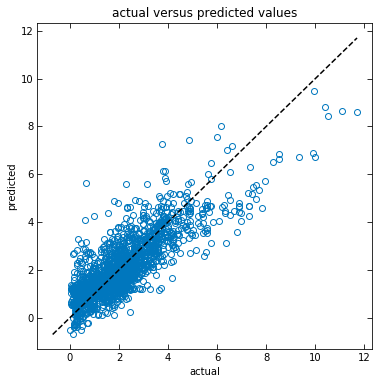

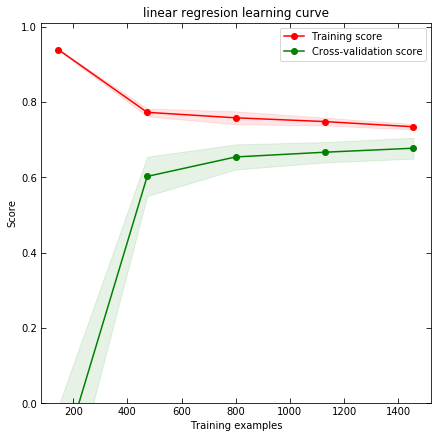

In [15]:
# Initialize a "LinearRegression" object. This will allow us to do a simple linear regression on the data
lr = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(lr, X_train_pca, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

title = "linear regresion learning curve"
utils.plot_learning_curve(lr, title, X_train_pca, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

### Ridge regression with lower feature dimensions

R2 score = 0.6713469521440221


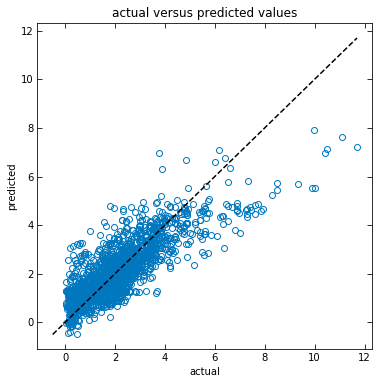

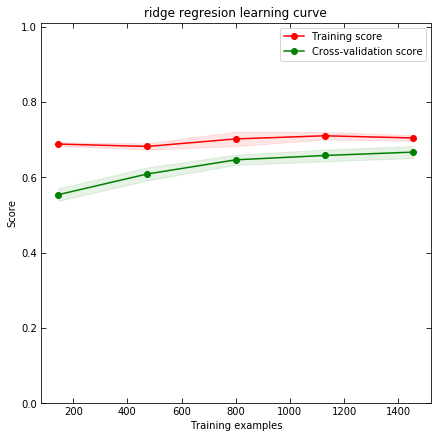

In [16]:
rr = Ridge()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(rr, X_train_pca, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

title = "ridge regresion learning curve"
utils.plot_learning_curve(rr, title, X_train_pca, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

## Moving to a random forest
**Poblems associated with using linear models include:**
1. limited model capacity (ridge & linear regression)
2. overfitting due to high feature dimensionality (linear regression)
3. unstable model results (high variance in cv performance)

The **random forest** algorithm leads to increased model capacity (can learn non-linear relationsihips), has built in feature selection, and is generally considered as a robust algorithm. This should help some of the problems we saw with the random forest regression.

**We will use the paremeter ```max_feature='sqrt'``` to reduce the number of features used for each decision from ~1000 to ~ 30. This drastically decreases the required modeling time**

R2 score = 0.7560537451254101


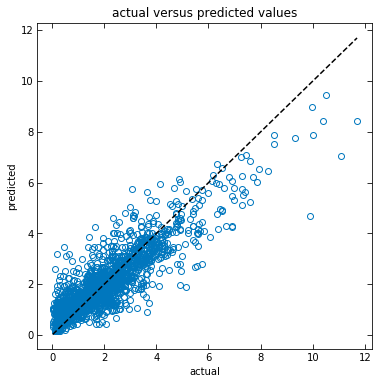

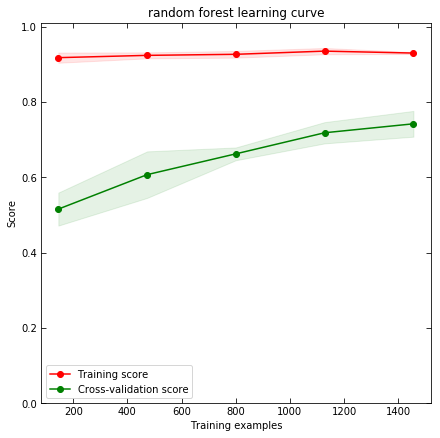

In [17]:
# Initialize a "RandomForestRegressor" object.
rf = RandomForestRegressor(max_features='sqrt')
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(rf, X_train, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

title = "random forest learning curve"
utils.plot_learning_curve(rf, title, X_train, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

### We can still increasing the number of estimators

Adding more estimators generally gives us a better model on the data. 

**Lets increase the number of decision trees we use by adding ```n_estimators=200``` to the function input**

R2 score = 0.776043296402757


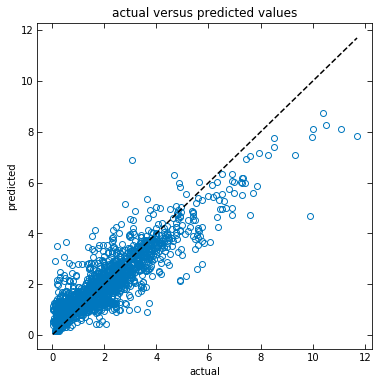

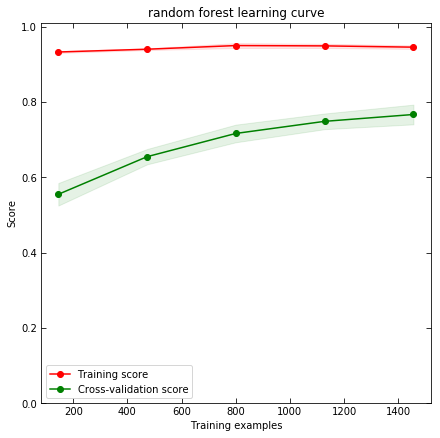

In [18]:
# Initialize a "RandomForestRegressor" object.
rf = RandomForestRegressor(n_estimators=300, max_features='sqrt')
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(rf, X_train, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

title = "random forest learning curve"
utils.plot_learning_curve(rf, title, X_train, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

## Model the data using a support vector machine

R2 score = 0.068256686624794


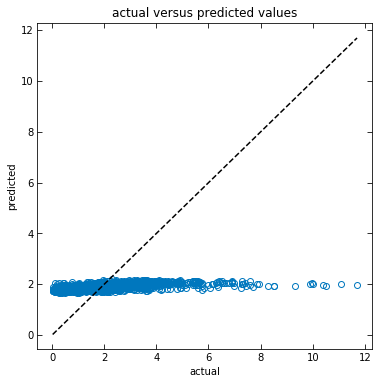

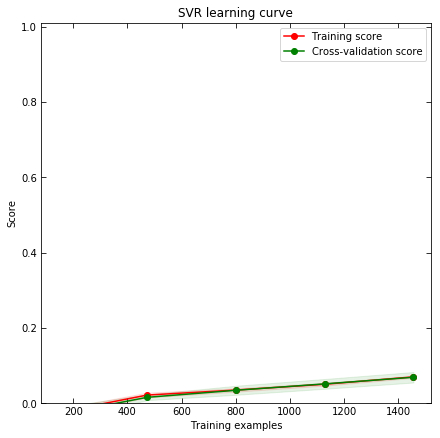

In [19]:
# Initialize a "SVR" object.
svr = SVR()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(svr, X_train_scaled, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

title = "SVR learning curve"
utils.plot_learning_curve(svr, title, X_train_scaled, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

### The SVR completely fails with the default parameters.

$$
min_{w,b}\frac{1}{2}||w||^2_2+C∑nζ_n \; s.t. \;  y_n(w^Tx_n+b)≥1−ζ_n
$$

$$
k(x_n,x_m)=exp(−γ||x_n−x_m||^2_2) 
$$

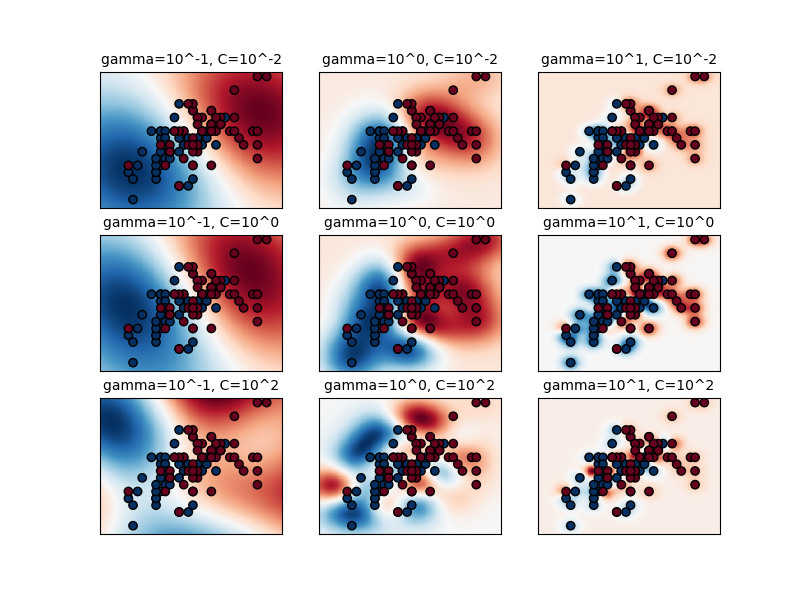

R2 score = 0.7734963549513862


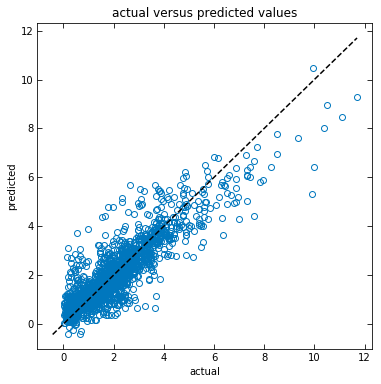

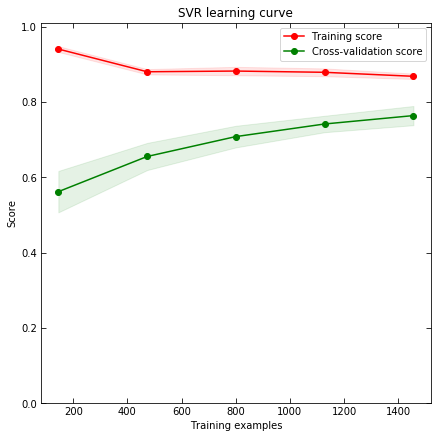

In [20]:
# Initialize a "SVR" object.
# high gamma, high model capacity (overfit)
# low gamma, low model capacity  (underfit)
# low C, lower capactiy (prefers larger margin)
# high C, high capacity (prefers smaller margi)
svr = SVR(C=100, gamma=0.1)
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(svr, X_train_scaled, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

title = "SVR learning curve"
utils.plot_learning_curve(svr, title, X_train_scaled, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

## Set up a grid search to begin optimization of the model parameters

Lets see if we can tweek the SVR hyperparameters to help improve our prediction capability

In [21]:
def grid_search(X, y, model, parameter_candidates, n_cv=3, title='Grid search results'):
    grid = GridSearchCV(estimator=model,
                        param_grid=parameter_candidates,
                        cv=n_cv,
                        n_jobs=4)
    grid.fit(X, y)
    return grid

svr = SVR()
array_C = np.logspace(-2, 1.7, 10)
array_gamma = np.logspace(-2, 1.7, 10)
parameter_candidates = {'C': array_C, 'gamma': array_gamma}

grid = grid_search(X_train_scaled, y_train, svr, parameter_candidates, n_cv=3, title='Grid search results')

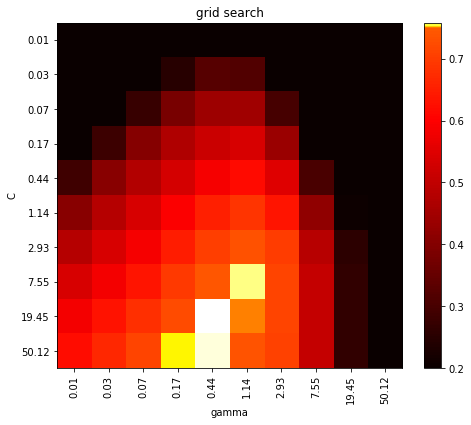

best parameters: {'C': 19.448624389373634, 'gamma': 0.44100594541767385}


In [24]:
utils.plot_grid_search(grid, midpoint=0.75)
print('best parameters:', grid.best_params_)

In [ ]:
best_svr = SVR(**)
best_svr.fit(X_train_scaled, y_train)
y_pred_test = best_svr.predict(X_test_scaled)

print('test score =', r2_score(y_test, y_pred_test))